# <div style="display: flex; justify-content: center; background-color:#90e0ef; font-family:Times New Roman; color:#03045e; padding: 10px; line-height: 1; border-radius: 70px; margin-bottom: 0em; text-align: center; font-size: 80px; border-style: solid; border-color: #90e0ef; font-weight: bold;"> Sea Creatures Detection</div>


<br>    
<p style="text-align: center;">
<img src="Images\customimage.jpg" style='width: 1000px; height: 650px;'>
</p>    

# <div style="background-color:#90e0ef; font-family:Times New Roman; color:#03045e; padding: 10px; line-height: 1; border-radius: 70px; margin-bottom: 0em; text-align: center; font-size: 40px; border-style: solid; border-color: #90e0ef; font-weight: bold;"> Importing Libraries</div>

In [1]:
import numpy as np  # Import NumPy for numerical operations
import tensorflow as tf  # Import TensorFlow for building and training models
import matplotlib.pyplot as plt  # Import Matplotlib for plotting and visualization
from tensorflow.keras.applications import MobileNetV2  # Import MobileNetV2 model from Keras applications
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  # Import preprocessing function for MobileNetV2
from sklearn.utils.class_weight import compute_class_weight  # Import function to compute class weights for imbalanced datasets
from tensorflow.keras.utils import image_dataset_from_directory  # Import function to create image datasets from directories
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard  # Import callbacks for early stopping and TensorBoard
import datetime  # Import datetime module for timestamping log directories

# <div style="background-color:#90e0ef; font-family:Times New Roman; color:#03045e; padding: 10px; line-height: 1; border-radius: 70px; margin-bottom: 0em; text-align: center; font-size: 40px; border-style: solid; border-color: #90e0ef; font-weight: bold;"> Loadint The DATA </div>

In [3]:
DataSetPath = "SeaDataset/SeaDataset/"  # Path to the dataset directory
BATCH_SIZE = 32  # Number of images per batch
IMAGE_HEIGHT = 224  # Height of the images
IMAGE_WIDTH = 224  # Width of the images
AUTOTUNE = tf.data.AUTOTUNE  # Auto-tune the data loading for performance

# Load all data from the directory, with images resized to 224x224 and labels as integers
all_data = image_dataset_from_directory(
    DataSetPath,  # Path to the dataset directory
    label_mode="int",  # Labels are integers
    batch_size=BATCH_SIZE,  # Number of images per batch
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # Resize images to 224x224 pixels
    seed=42,  # Seed for shuffling
    verbose=True  # Verbose output
)

class_names = all_data.class_names  # Get the class names from the dataset

# Shuffle the dataset with a buffer size of 1000 and a seed for reproducibility
all_data = all_data.shuffle(1000, seed=42)

# Calculate the sizes of the train, validation, and test datasets
dataset_size = len(all_data)  # Total number of batches in the dataset
train_size = int(0.7 * dataset_size)  # 70% of the dataset for training
val_size = int(0.2 * dataset_size)  # 20% of the dataset for validation
test_size = dataset_size - train_size - val_size  # Remaining 10% for testing

# Split the dataset into training, validation, and test sets
train_dataset = all_data.take(train_size)  # Take the first 70% for training
val_dataset = all_data.skip(train_size).take(val_size)  # Skip the training set and take the next 20% for validation
test_dataset = all_data.skip(train_size + val_size)  # Skip the training and validation sets to get the test set

Found 12451 files belonging to 23 classes.


In [4]:
print(f"Using {train_size * BATCH_SIZE} files for training.")  # Print the number of files used for training
print(f"Using {val_size * BATCH_SIZE} files for validation.")  # Print the number of files used for validation
print(f"Using {test_size * BATCH_SIZE} files for testing.")  # Print the number of files used for testing

Using 8736 files for training.
Using 2496 files for validation.
Using 1248 files for testing.


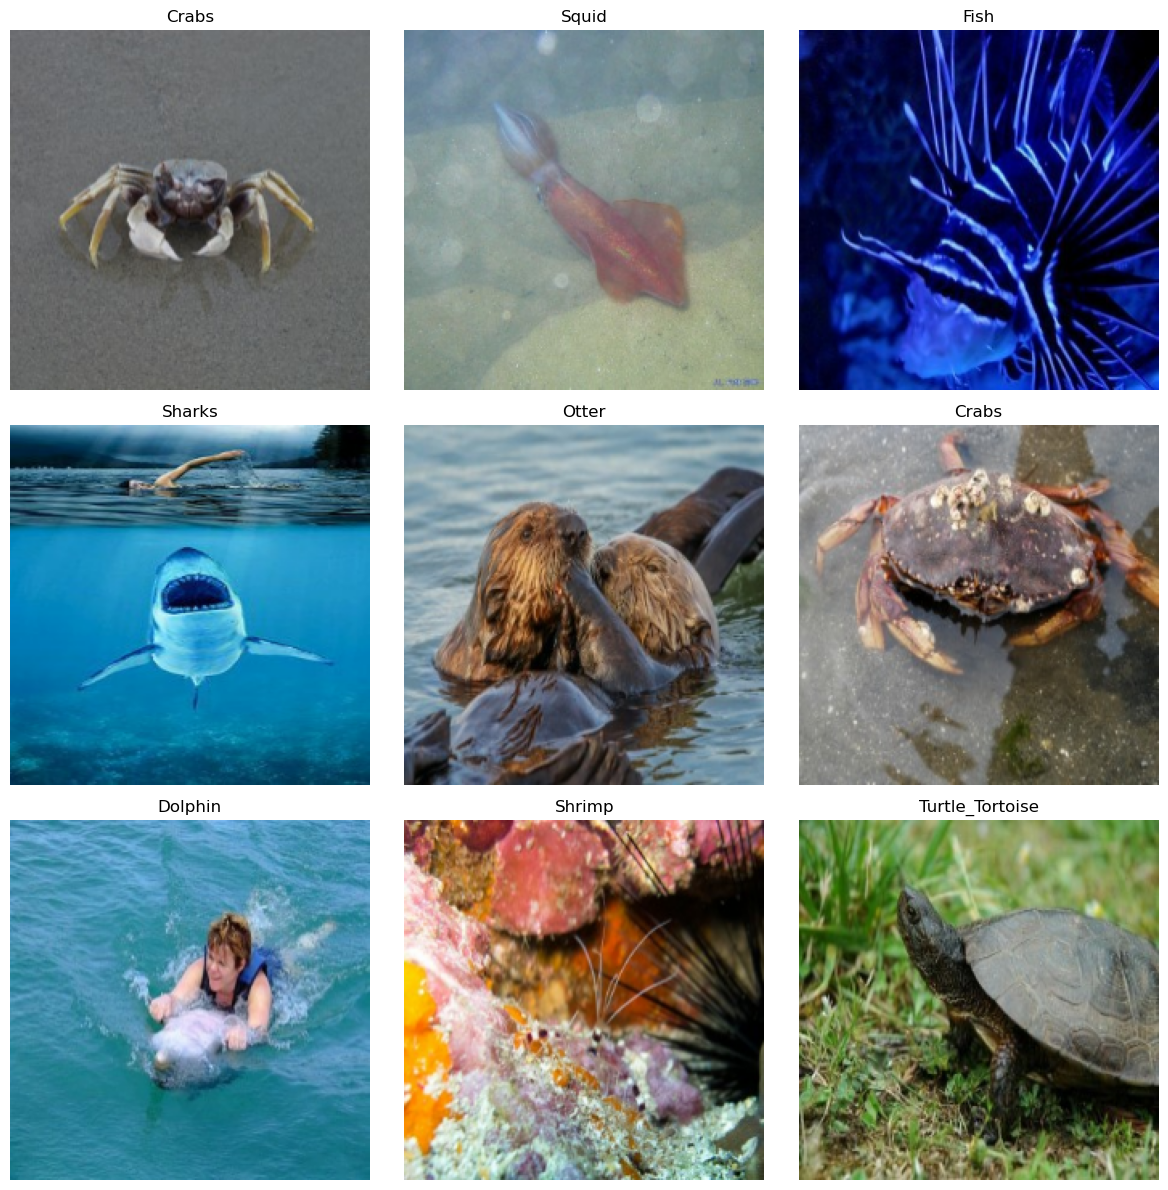

In [5]:
for images, labels in train_dataset.take(1):  # Take one batch of images and labels from the training dataset
    plt.figure(figsize=(12, 12))  # Create a new figure with a size of 12x12 inches
    for i in range(9):  # Loop through the first 9 images in the batch
        ax = plt.subplot(3, 3, i + 1)  # Create a 3x3 grid of subplots and select the (i+1)th subplot
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the image, converting it to uint8 format
        plt.title(class_names[labels[i]])  # Set the title of the subplot to the class name of the image
        plt.axis("off")  # Turn off the axis
    plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the figure

# <div style="background-color:#90e0ef; font-family:Times New Roman; color:#03045e; padding: 10px; line-height: 1; border-radius: 70px; margin-bottom: 0em; text-align: center; font-size: 40px; border-style: solid; border-color: #90e0ef; font-weight: bold;"> Data Preprocessing</div>

In [6]:
# Data augmentation
data_augmentation = tf.keras.Sequential([  # Create a sequential model for data augmentation
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    tf.keras.layers.RandomRotation(0.2),  # Randomly rotate images by up to 20%
    tf.keras.layers.RandomZoom(0.2),  # Randomly zoom into images by up to 20%
    tf.keras.layers.RandomTranslation(0.2, 0.2)  # Randomly translate images by up to 20% in both directions
])

# Prepare the datasets with augmentation and normalization
train_dataset = train_dataset.map(  # Apply data augmentation and preprocessing to the training dataset
    lambda x, y: (preprocess_input(data_augmentation(x, training=True)), y),  # Apply data augmentation and preprocess input
    num_parallel_calls=AUTOTUNE  # Use AUTOTUNE to optimize the data loading
)

val_dataset = val_dataset.map(  # Apply preprocessing to the validation dataset
    lambda x, y: (preprocess_input(x), y),  # Preprocess input without augmentation
    num_parallel_calls=AUTOTUNE  # Use AUTOTUNE to optimize the data loading
)

test_dataset = test_dataset.map(  # Apply preprocessing to the test dataset
    lambda x, y: (preprocess_input(x), y),  # Preprocess input without augmentation
    num_parallel_calls=AUTOTUNE  # Use AUTOTUNE to optimize the data loading
)

Class: Clams, Count: 272
Class: Corals, Count: 356
Class: Crabs, Count: 333
Class: Dolphin, Count: 539
Class: Eel, Count: 283
Class: Fish, Count: 240
Class: Jelly Fish, Count: 613
Class: Lobster, Count: 275
Class: Nudibranchs, Count: 352
Class: Octopus, Count: 389
Class: Otter, Count: 344
Class: Penguin, Count: 321
Class: Puffers, Count: 306
Class: Sea Rays, Count: 318
Class: Sea Urchins, Count: 384
Class: Seahorse, Count: 329
Class: Seal, Count: 189
Class: Sharks, Count: 397
Class: Shrimp, Count: 282
Class: Squid, Count: 258
Class: Starfish, Count: 317
Class: Turtle_Tortoise, Count: 1264
Class: Whale, Count: 375


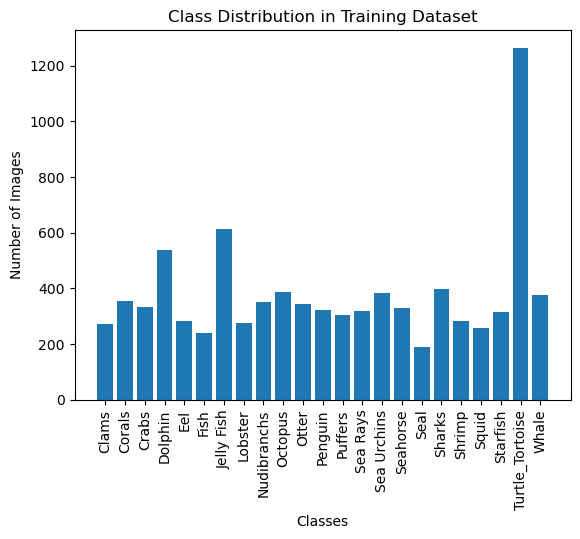

In [7]:
# Calculate class weights
labels = np.concatenate([y.numpy() for x, y in train_dataset], axis=0)  # Concatenate all labels from the training dataset into a single array

# Calculate the count of each class
class_counts = np.bincount(labels)  # Count the number of occurrences of each class label

# Print the count of each class
for class_name, count in zip(class_names, class_counts):  # Iterate over class names and their corresponding counts
    print(f"Class: {class_name}, Count: {count}")  # Print the class name and its count

# Plot the class distribution
plt.bar(class_names, class_counts)  # Create a bar plot of class counts
plt.xlabel('Classes')  # Set the x-axis label
plt.ylabel('Number of Images')  # Set the y-axis label
plt.title('Class Distribution in Training Dataset')  # Set the title of the plot
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees for better readability
plt.show()  # Display the plot

# <div style="background-color:#90e0ef; font-family:Times New Roman; color:#03045e; padding: 10px; line-height: 1; border-radius: 70px; margin-bottom: 0em; text-align: center; font-size: 40px; border-style: solid; border-color: #90e0ef; font-weight: bold;"> Modeling & Fine Tuning</div>

In [8]:
# Compute class weights to handle imbalanced data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weight_dict)

{0: 1.3964194373401535, 1: 1.0669272105520273, 2: 1.1406188797493146, 3: 0.704686617730096, 4: 1.342141650023045, 5: 1.5826086956521739, 6: 0.6196184126533797, 7: 1.3811857707509883, 8: 1.0790513833992095, 9: 0.9764166759807756, 10: 1.1041456016177957, 11: 1.1832588378707842, 12: 1.2412617220801363, 13: 1.1944216570959802, 14: 0.9891304347826086, 15: 1.154486586493987, 16: 2.0096618357487923, 17: 0.9567407731902311, 18: 1.3469010175763183, 19: 1.4721941354903942, 20: 1.1981895487587437, 21: 0.30049532195927353, 22: 1.0128695652173914}


In [9]:
# Define early stopping callback to stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor the validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1  # Verbose output
)

# Set up TensorBoard callback with a log directory based on the current date and time
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # Create a log directory with a timestamp
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)  # Set up TensorBoard callback to log training metrics

In [10]:
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)  # Cache the training dataset and prefetch batches for improved performance
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)  # Cache the validation dataset and prefetch batches for improved performance
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)  # Cache the test dataset and prefetch batches for improved performance

In [11]:
# Load the MobileNetV2 model with pre-trained weights from ImageNet, excluding the top classification layer
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = True  # Set the base model to be trainable

# Fine-tune the model by freezing the first 110 layers
fine_tune_at = 110
for layer in base_model.layers[:fine_tune_at]:  # Iterate over the first 110 layers
    layer.trainable = False  # Freeze these layers (do not train them)

# Define the input layer for the model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# Pass the inputs through the base model
x = base_model(inputs, training=False)

# Add a global average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a dense output layer with softmax activation for classification
outputs = tf.keras.layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)

# Create the final model
mobilenet_model = tf.keras.Model(inputs, outputs)

# Compile the model with sparse categorical cross-entropy loss, Adam optimizer, and accuracy metric
mobilenet_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Loss function for multi-class classification
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  # Adam optimizer with a low learning rate for fine-tuning
    metrics=["accuracy"]  # Metric to evaluate during training and testing
)

# Display the model summary
mobilenet_model.summary()  # Print the model architecture and parameters

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 23)             │        29,463 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,287,447 (8.73 MB)

 Trainable params: 1,772,631 (6.76 MB)

 Non-trainable params: 514,816 (1.96 MB)

In [12]:
# Train the model with the training dataset, validation dataset, class weights, and callbacks
history = mobilenet_model.fit(
    train_dataset,  # Training dataset
    epochs=10,  # Number of epochs to train the model
    validation_data=val_dataset,  # Validation dataset to monitor performance during training
    class_weight=class_weight_dict,  # Class weights to handle class imbalance
    callbacks=[early_stopping, tensorboard_callback]  # List of callbacks to use during training (early stopping and TensorBoard)
)

Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 462s 1s/step - accuracy: 0.1162 - loss: 3.1342 - val_accuracy: 0.4103 - val_loss: 2.1804
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - accuracy: 0.4351 - loss: 2.0666 - val_accuracy: 0.6058 - val_loss: 1.5262
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.6021 - loss: 1.5285 - val_accuracy: 0.6787 - val_loss: 1.1784
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 269s 986ms/step - accuracy: 0.6793 - loss: 1.2252 - val_accuracy: 0.7216 - val_loss: 0.9819
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.7279 - loss: 1.0299 - val_accuracy: 0.7512 - val_loss: 0.8638
Epoch 6/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.7684 - loss: 0.8873 - val_accuracy: 0.7788 - val_loss: 0.7870
Epoch 7/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.7961 - loss: 0.7737 - val_accuracy: 0.7905 - val_loss: 0.7328
Epoch 8/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.8270 - loss: 0.6785 - val_a

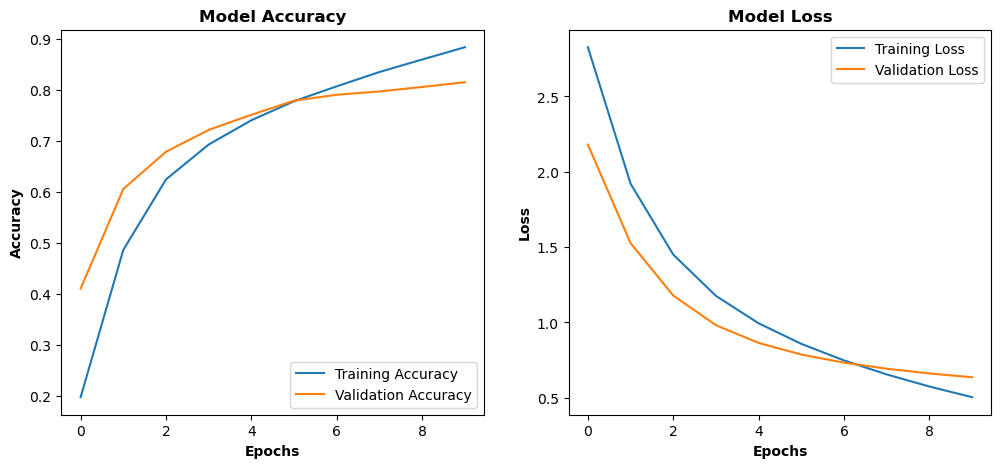

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy", fontweight="bold")
plt.xlabel("Epochs", fontweight="bold")
plt.ylabel("Accuracy", fontweight="bold")
plt.legend(loc="lower right");

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss", fontweight="bold")
plt.xlabel("Epochs", fontweight="bold")
plt.ylabel("Loss", fontweight="bold")
plt.legend(loc="best");

# <div style="background-color:#90e0ef; font-family:Times New Roman; color:#03045e; padding: 10px; line-height: 1; border-radius: 70px; margin-bottom: 0em; text-align: center; font-size: 40px; border-style: solid; border-color: #90e0ef; font-weight: bold;"> Testing Phase</div>

In [15]:
test_loss, test_accuracy = mobilenet_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 88s 648ms/step - accuracy: 0.8005 - loss: 0.6536
Test Accuracy: 0.80


In [20]:
def test_model_predictions(model, test_dataset, class_names, num_images=15, title_fontsize=12):
    # Convert dataset to an iterator
    test_iterator = iter(test_dataset.shuffle(buffer_size=1000))  # Shuffle the test dataset and create an iterator

    random_images = []  # List to store random images
    random_true_labels = []  # List to store true labels of the random images

    # Retrieve random images and their labels
    for _ in range(num_images):  # Loop to get a specified number of random images
        images, labels = next(test_iterator)  # Get the next batch of images and labels from the iterator
        random_images.append(images[0].numpy())  # Convert the first image in the batch to a NumPy array and add to the list
        random_true_labels.append(labels[0].numpy())  # Convert the first label in the batch to a NumPy array and add to the list

    random_images = np.array(random_images)  # Convert the list of images to a NumPy array
    random_true_labels = np.array(random_true_labels)  # Convert the list of labels to a NumPy array

    # Model predictions
    predictions = model.predict(random_images)  # Get model predictions for the random images
    predicted_labels = np.argmax(predictions, axis=1)  # Get the predicted class labels

    # Reverse the effects of preprocess_input
    def reverse_preprocess_input(image):
        image = image * 127.5 + 127.5  # Reverse normalization applied during preprocessing
        return np.clip(image, 0, 255).astype("uint8")  # Clip values to the range [0, 255] and cast to uint8

    # Plot images with true and predicted labels
    plt.figure(figsize=(15, 10))  # Create a new figure with a size of 15x10 inches
    for i in range(num_images):  # Loop through the number of images to display
        ax = plt.subplot(3, 5, i + 1)  # Create a 3x5 grid of subplots and select the (i+1)th subplot
        
        # Reverse preprocessing
        image_to_display = reverse_preprocess_input(random_images[i])  # Reverse the preprocessing for display
        
        plt.imshow(image_to_display)  # Display the image
        plt.axis("off")  # Turn off the axis
        
        true_label = class_names[random_true_labels[i]]  # Get the true class name
        predicted_label = class_names[predicted_labels[i]]  # Get the predicted class name
        
        color = "green" if predicted_label == true_label else "red"  # Set the title color based on prediction correctness
        ax.set_title(f"Pred: {predicted_label}\nTrue: {true_label}", 
                    color=color, fontsize=title_fontsize, fontweight="bold")  # Set the title with predicted and true labels

    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()  # Display the figure

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


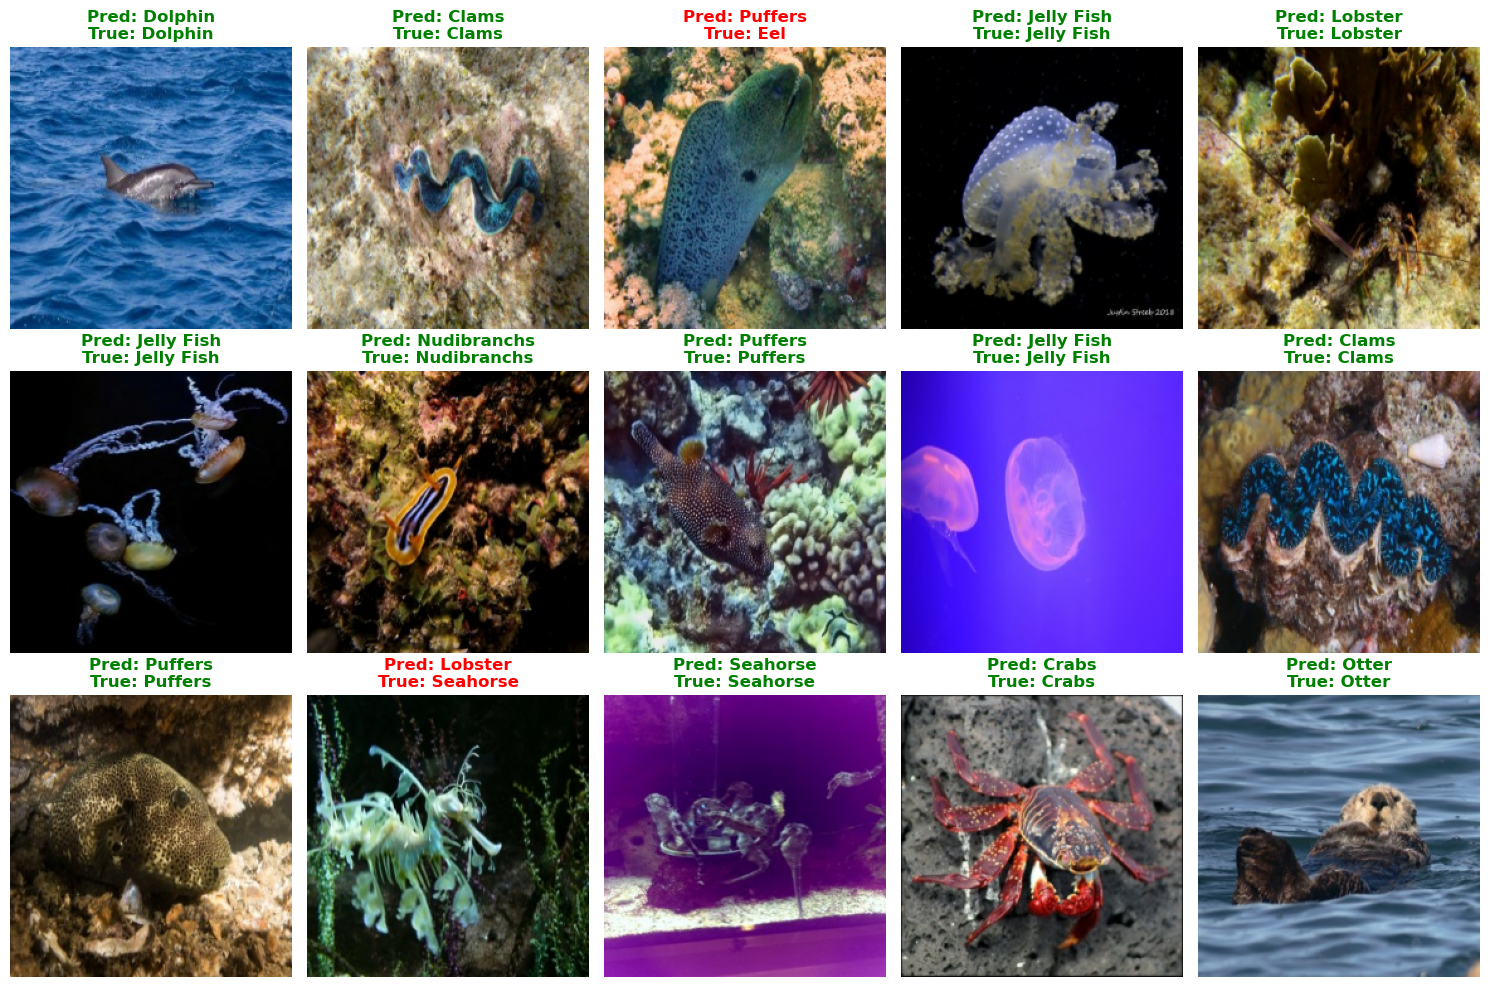

In [21]:
test_model_predictions(mobilenet_model, test_dataset, class_names, num_images=15, title_fontsize=12)

# <div style="background-color:#90e0ef; font-family:Times New Roman; color:#03045e; padding: 10px; line-height: 1; border-radius: 70px; margin-bottom: 0em; text-align: center; font-size: 40px; border-style: solid; border-color: #90e0ef; font-weight: bold;"> Saving The Best Model</div>

In [28]:
# Save the model
mobilenet_model.save("mobilenet_model3.h5")

# <div style="background-color:#90e0ef; font-family:Times New Roman; color:#03045e; padding: 10px; line-height: 1; border-radius: 70px; margin-bottom: 0em; text-align: center; font-size: 40px; border-style: solid; border-color: #90e0ef; font-weight: bold;"> Thank You</div>